<center>
    <h1>Coursera - Applied Data Science Capstone</h1>
    <h2>Peer-graded Assignment: Segmenting and Clustering Neighborhoods in Toronto</h2>
</center>

***

## Table of Contents



1.<a href="#item1">Requirement #1: Fetching Canada Postal Codes and preparing the DataFrame</a>

2.<a href="#item2">Requirement #2: Complementing the Longitude and Latitude infiormation for the different Postal Codes (using Geocoder and Provided GeoLocation Lookup CSV File)</a>

3.<a href="#item3">Requirement #3: Plotting the Postal Codes on a map</a>



***

## <a id='item1'>Requirements #1</a>

### - Use the Notebook to build the code to scrape the following Wikipedia page, https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M, in order to obtain the data that is in the table of postal codes and to transform the data into a pandas dataframe like the one shown below:


In [1]:
# library for data analysis
import pandas as pd 

# library to handle requests
import requests 

# library to parse HTML documents
from bs4 import BeautifulSoup 

In [2]:
# get the response in the form of html
wikiurl=" https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"
table_class="wikitable sortable"
response=requests.get(wikiurl)
print("HTTP Status Code: " + str(response.status_code))
# print(response.text)

HTTP Status Code: 200


In [3]:
# parse data from the html into a beautifulsoup object
soup = BeautifulSoup(response.text, 'html.parser')
codestable=soup.find('table',{'class':table_class})
# print(codestable)

### - convert table into  dataframe. The dataframe will consist of three columns: PostalCode, Borough, and Neighborhood

In [4]:
df_codes=pd.read_html(str(codestable))

df_codes=pd.DataFrame(df_codes[0])

df_codes.rename(columns={'Neighbourhood':'Neighborhood'}, inplace=True)

print(df_codes.head(10))

  Postal Code           Borough                                 Neighborhood
0         M1A      Not assigned                                 Not assigned
1         M2A      Not assigned                                 Not assigned
2         M3A        North York                                    Parkwoods
3         M4A        North York                             Victoria Village
4         M5A  Downtown Toronto                    Regent Park, Harbourfront
5         M6A        North York             Lawrence Manor, Lawrence Heights
6         M7A  Downtown Toronto  Queen's Park, Ontario Provincial Government
7         M8A      Not assigned                                 Not assigned
8         M9A         Etobicoke      Islington Avenue, Humber Valley Village
9         M1B       Scarborough                               Malvern, Rouge


In [5]:
# The code was removed by Watson Studio for sharing.

In [6]:
# Save Codes Dataframe into a CSV file for debugging 
from project_lib import Project

project = Project(project_id=project_id, project_access_token=project_token)
pc = project.project_context
project.save_data(data=df_codes.to_csv(index=False),file_name='canada_codes.csv',overwrite=True)

{'file_name': 'canada_codes.csv',
 'message': 'File saved to project storage.',
 'bucket_name': 'courseracapstoneproject-donotdelete-pr-hus2xobrw8txte',
 'asset_id': '7987bb01-6db2-408b-9216-6a1367561b65'}

### - Only process the cells that have an assigned borough. Ignore cells with a borough that is Not assigned.

In [7]:
df_codes = df_codes[df_codes["Borough"] != 'Not assigned']

### - More than one neighborhood can exist in one postal code area. For example, in the table on the Wikipedia page, you will notice that M5A is listed twice and has two neighborhoods: Harbourfront and Regent Park. These two rows will be combined into one row with the neighborhoods separated with a comma as shown in row 11 in the above table.

In [8]:
# Data table from Wikipedia is already grouped/aggregated

### - If a cell has a borough but a Not assigned neighborhood, then the neighborhood will be the same as the borough.

In [9]:
for index, row in df_codes.iterrows():
    neighborhood = row['Neighborhood']
    borough = row['Borough']
    # print(str(index) + "|" + neighborhood + "|" + borough)
    if (str(neighborhood).find('Not assigned') != -1 ): 
        df_codes['Neighborhood'][index] = df_codes[index]['Borough']

df_codes = df_codes.reset_index(drop=True)
df_codes.head(11)

Postal Code           Borough                                 Neighborhood
0          M3A        North York                                    Parkwoods
1          M4A        North York                             Victoria Village
2          M5A  Downtown Toronto                    Regent Park, Harbourfront
3          M6A        North York             Lawrence Manor, Lawrence Heights
4          M7A  Downtown Toronto  Queen's Park, Ontario Provincial Government
5          M9A         Etobicoke      Islington Avenue, Humber Valley Village
6          M1B       Scarborough                               Malvern, Rouge
7          M3B        North York                                    Don Mills
8          M4B         East York              Parkview Hill, Woodbine Gardens
9          M5B  Downtown Toronto                     Garden District, Ryerson
10         M6B        North York                                    Glencairn

### - Clean your Notebook and add Markdown cells to explain your work and any assumptions you are making.

### - In the last cell of your notebook, use the .shape method to print the number of rows of your dataframe.

In [10]:
# df_codes dimentions
df_codes.shape

(103, 3)

***

## <a id='item2'>Requrements # 2</a>


### - Now that you have built a dataframe of the postal code of each neighborhood along with the borough name and neighborhood name, in order to utilize the Foursquare location data, we need to get the latitude and the longitude coordinates of each neighborhood.

### - In an older version of this course, we were leveraging the Google Maps Geocoding API to get the latitude and the longitude coordinates of each neighborhood. However, recently Google started charging for their API: http://geoawesomeness.com/developers-up-in-arms-over-google-maps-api-insane-price-hike/, so we will use the Geocoder Python package instead: https://geocoder.readthedocs.io/index.html.

### - The problem with this Package is you have to be persistent sometimes in order to get the geographical coordinates of a given postal code. So you can make a call to get the latitude and longitude coordinates of a given postal code and the result would be None, and then make the call again and you would get the coordinates. So, in order to make sure that you get the coordinates for all of our neighborhoods, you can run a while loop for each postal code. Taking postal code M5G as an example, your code would look something like this:

In [11]:
# Installing Geocoder
!pip install geocoder

In [12]:
# Add the Longitude and Latitude columns  
df_codes['Longitude'] = 0.0
df_codes['Latitude'] = 0.0

df_codes.head()

Postal Code           Borough                                 Neighborhood  \
0         M3A        North York                                    Parkwoods   
1         M4A        North York                             Victoria Village   
2         M5A  Downtown Toronto                    Regent Park, Harbourfront   
3         M6A        North York             Lawrence Manor, Lawrence Heights   
4         M7A  Downtown Toronto  Queen's Park, Ontario Provincial Government   

   Longitude  Latitude  
0        0.0       0.0  
1        0.0       0.0  
2        0.0       0.0  
3        0.0       0.0  
4        0.0       0.0

In [13]:
# Load the geolocation data CSV file to use when no location is found from the GeoCoder
geo_lookup = pd.read_csv("http://cocl.us/Geospatial_data")
geo_lookup.head()
geo_lookup['Longitude'] = geo_lookup['Longitude'].astype(float)
geo_lookup['Latitude'] = geo_lookup['Latitude'].astype(float)
geo_lookup.set_index('Postal Code')
geo_lookup.head()

Postal Code   Latitude  Longitude
0         M1B  43.806686 -79.194353
1         M1C  43.784535 -79.160497
2         M1E  43.763573 -79.188711
3         M1G  43.770992 -79.216917
4         M1H  43.773136 -79.239476

In [14]:
geo_lookup.shape

(103, 3)

### - Complementing the Longitude and Latitude information 
### - Attempting to fetch the Geo Loction Location information using the Geocoder APIs, and then reverting to the GeoLocation Lookup data when the API fails

In [15]:
# import geocoder
import geocoder
from geopy.geocoders import Nominatim
base_address = 'Canada'
geolocator = Nominatim(user_agent="canada_explorer")
location = geolocator.geocode(base_address)
ca_latitude = location.latitude
ca_longitude = location.longitude
print('The geograpical coordinate of Canada are {}, {}.'.format(ca_latitude, ca_longitude))

latitude = 0.0
longitude = 0.0

for index, row in df_codes.iterrows():
    neighborhood = row['Neighborhood']
    borough = row['Borough']
    postal_code = row['Postal Code']
    address =  postal_code  + ', ' + base_address #+ ',' + borough
    location = geolocator.geocode(address)
    if(location is not None):
        latitude = location.latitude
        longitude = location.longitude
#         print('Geolocation Found {} Long/Lat {}/{}'.format(address, longitude, latitude))
    else:
        df = geo_lookup[geo_lookup['Postal Code'].isin([postal_code])]
        if (df is not None):
            longitude = df['Longitude'].iloc[0]
            latitude =df['Latitude'].iloc[0]
#             print('Found {} Long/Lat {}/{} using Location Lookup table'.format(address, longitude, latitude))
    df_codes['Longitude'][index] = float(longitude)
    df_codes['Latitude'][index] = float(latitude)
    longitude = 0.0
    latitude = 0.0


The geograpical coordinate of Canada are 61.0666922, -107.9917071.


/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [16]:
df_codes.head()

Postal Code           Borough                                 Neighborhood  \
0         M3A        North York                                    Parkwoods   
1         M4A        North York                             Victoria Village   
2         M5A  Downtown Toronto                    Regent Park, Harbourfront   
3         M6A        North York             Lawrence Manor, Lawrence Heights   
4         M7A  Downtown Toronto  Queen's Park, Ontario Provincial Government   

   Longitude   Latitude  
0 -78.506920  -0.205540  
1 -79.315572  43.725882  
2 -79.360636  43.654260  
3 -79.464763  43.718518  
4 -78.506920  -0.205540

***

## <a id='item3'>Requirement #3</a>

### - to generate maps to visualize your neighborhoods and how they cluster together.

### - The First maps below is generated from the Wiki table and the attempt to lookup the Geo Location information using the APIs (reverting to the Postal Code location lookup when the API fails)
### - The second map is for the locations listed in the GeoLocation Lookup file. (only form comparison)
### - The GeoLocation APIs were unreliable, failed to retreive the Lon/Lat about 77% of the times.

In [17]:
!pip install folium

In [18]:
# map rendering library
import folium 

# create map of New York using latitude and longitude values
map_canada = folium.Map(location=[geo_lookup['Latitude'][1], geo_lookup['Longitude'][1]], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(df_codes['Latitude'], df_codes['Longitude'], df_codes['Borough'], df_codes['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_canada)  
    
map_canada

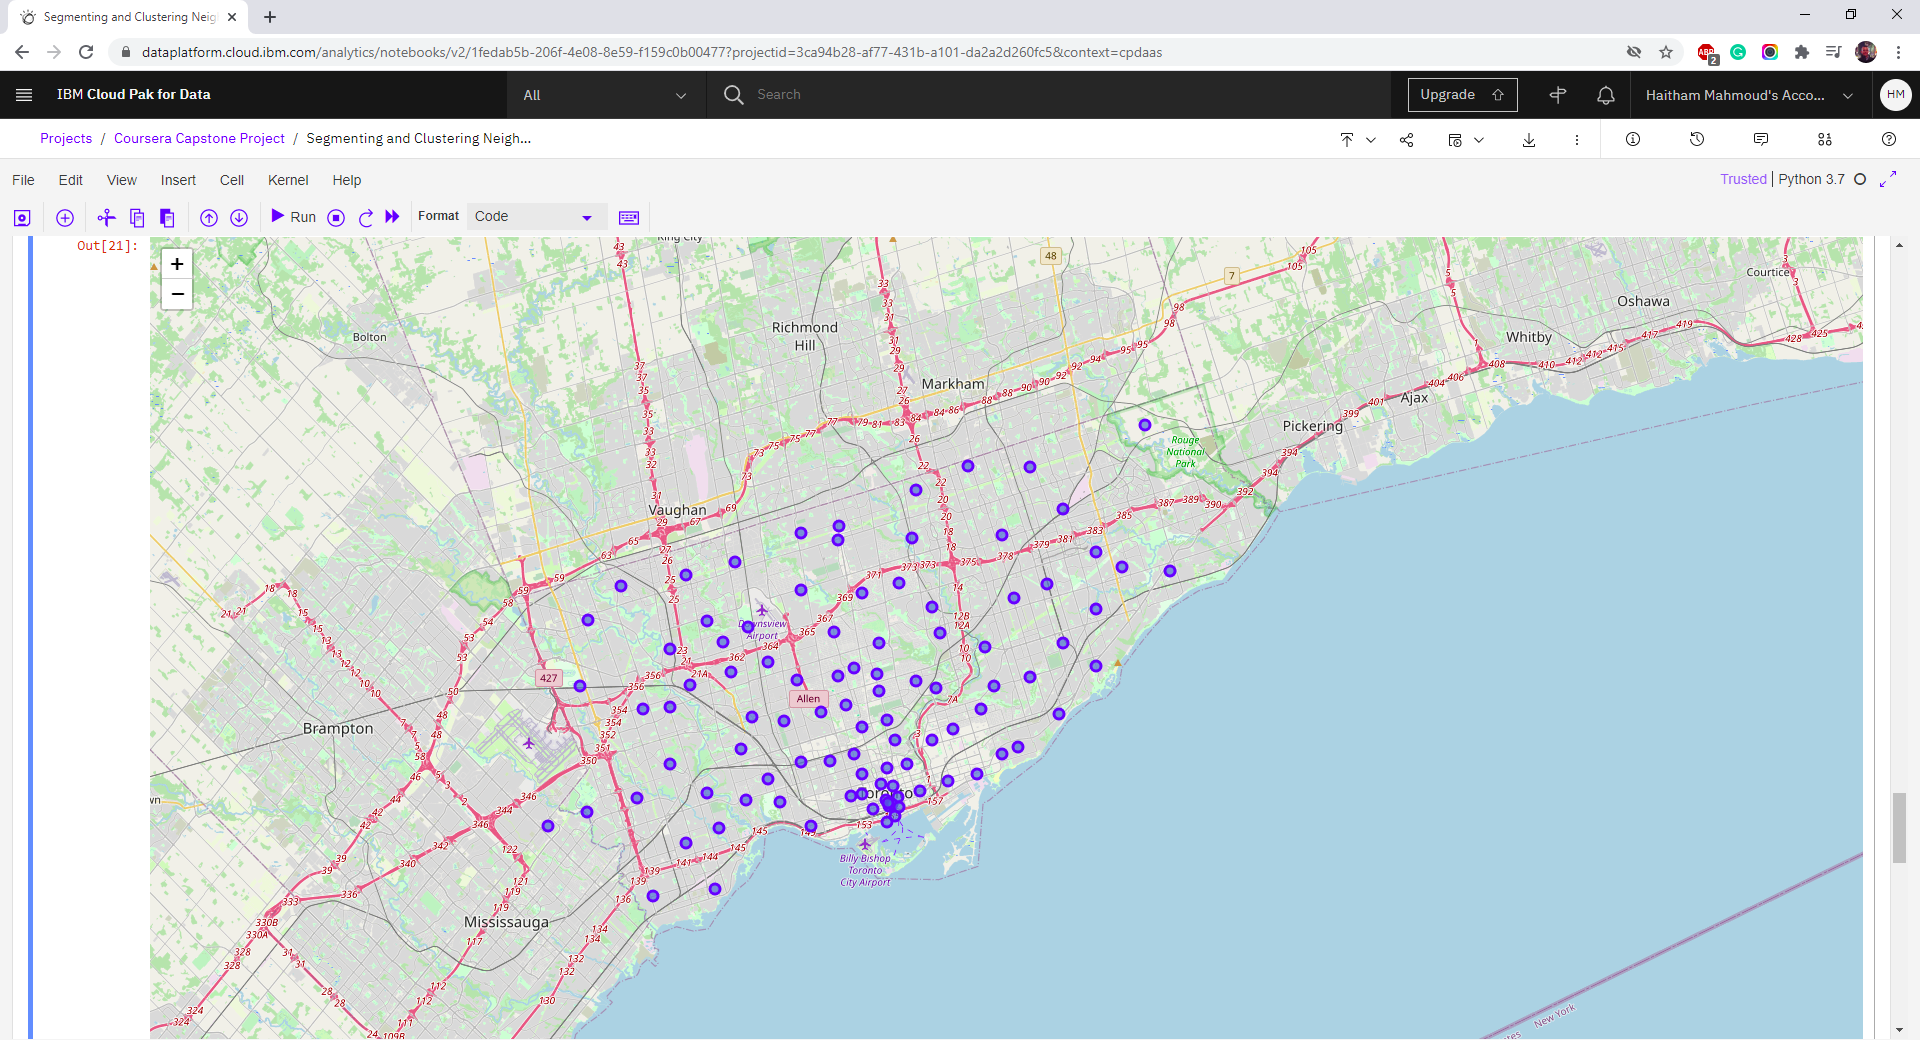

### - Similar map using the Postal Codes Lookup file (for comparision with the Wiki Data) 

In [19]:
map_canada = folium.Map(location=[geo_lookup['Latitude'][1], geo_lookup['Longitude'][1]], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(geo_lookup['Latitude'], geo_lookup['Longitude'], geo_lookup['Postal Code'], geo_lookup['Postal Code']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_canada)  
    
map_canada

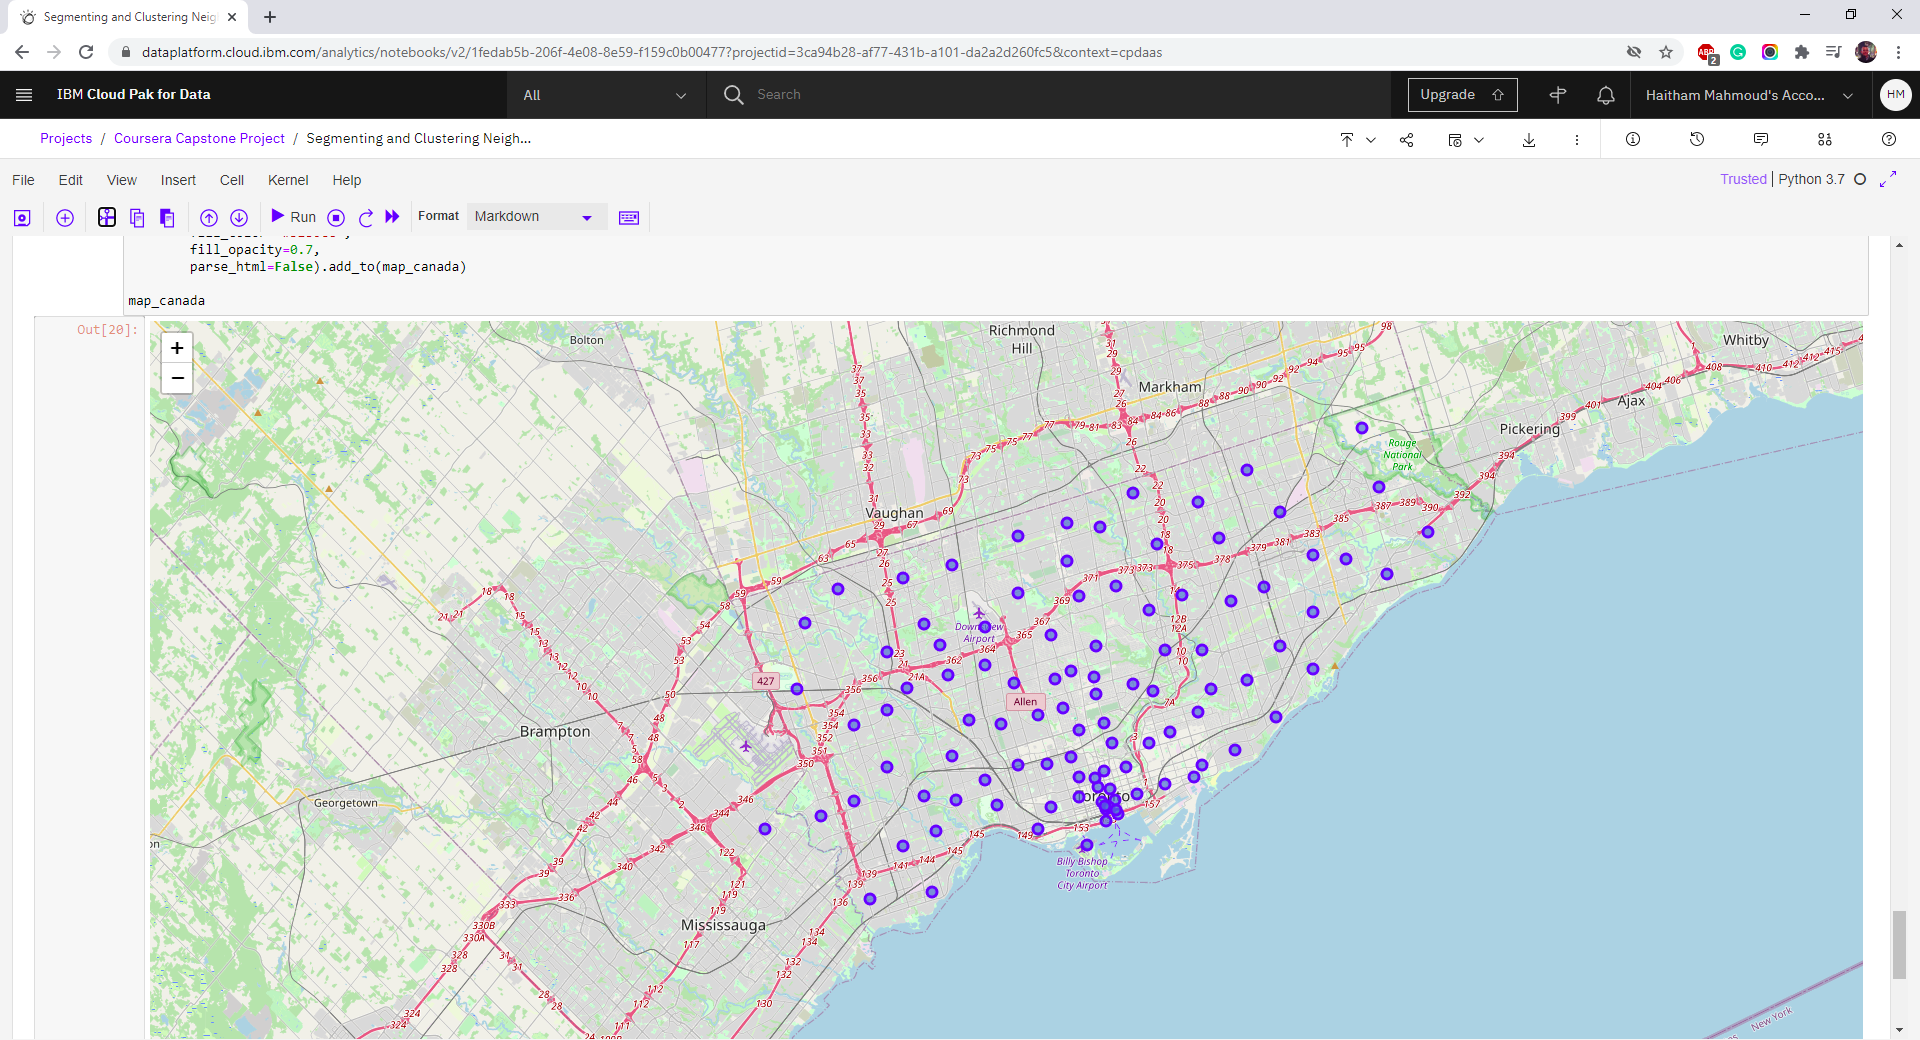

### Clustring The Locations In Canada

Next, we are going to start utilizing the Foursquare API to explore the neighborhoods and segment them.

#### Define Foursquare Credentials and Version

In [20]:
CLIENT_ID = 'your-client-ID' # your Foursquare ID
CLIENT_SECRET = 'your-client-secret' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: your-client-ID
CLIENT_SECRET:your-client-secret


#### Let's explore the first neighborhood in our dataframe.

Get the neighborhood's name.

In [21]:
df_codes.loc[0, 'Neighborhood']

'Parkwoods'

Get the neighborhood's latitude and longitude values.

In [22]:
neighborhood_latitude = df_codes.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = df_codes.loc[0, 'Longitude'] # neighborhood longitude value

In [23]:
neighborhood_name = df_codes.loc[0, 'Neighborhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Parkwoods are -0.20554, -78.5069204.


#### Now, let's get the top 100 venues that are in Marble Hill within a radius of 500 meters.

First, let's create the GET request URL. Name your URL **url**.

In [24]:
# The code was removed by Watson Studio for sharing.

In [25]:
# type your answer here
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 500 # define radius
# create URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)

In [26]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5fbc7976da740e58ce8a0d21'},
 'response': {'headerLocation': 'América',
  'headerFullLocation': 'América, Quito',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 4,
  'suggestedBounds': {'ne': {'lat': -0.2010399954999955,
    'lng': -78.50242876862177},
   'sw': {'lat': -0.2100400045000045, 'lng': -78.51141203137823}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '502af1d7e4b034701419d874',
       'name': 'Hamburguesas al Carbon',
       'location': {'lat': -0.2028561727209441,
        'lng': -78.50458028597174,
        'labeledLatLngs': [{'label': 'display',
          'lat': -0.2028561727209441,
          'lng': -78.50458028597174}],
        'distance': 396,
        'cc': 'EC',
        'city': 'Quito',
        'stat

From the Foursquare lab in the previous module, we know that all the information is in the _items_ key. Before we proceed, let's borrow the **get_category_type** function from the Foursquare lab.

In [27]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

Now we are ready to clean the json and structure it into a _pandas_ dataframe.

In [28]:
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

venues = results['response']['groups'][0]['items']    
nearby_venues = json_normalize(venues) # flatten JSON

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:4: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead


In [29]:
# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

In [30]:
# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

In [31]:
# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

name            categories       lat        lng
0  Hamburguesas al Carbon          Burger Joint -0.202856 -78.504580
1                     KFC  Fast Food Restaurant -0.205336 -78.502605
2  Los Palmares Manabitas    Seafood Restaurant -0.208005 -78.503505
3   Los Motes De san Juan            Food Truck -0.208957 -78.509685

And how many venues were returned by Foursquare?

In [32]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

4 venues were returned by Foursquare.


<a id='item2'></a>

## 2. Explore Neighborhoods in Manhattan

#### Let's create a function to repeat the same process to all the neighborhoods in Manhattan

In [33]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

#### Now write the code to run the above function on each neighborhood and create a new dataframe called _manhattan_venues_.

In [34]:
# type your answer here
canada_venues = getNearbyVenues(names=df_codes['Neighborhood'],
                                   latitudes=df_codes['Latitude'],
                                   longitudes=df_codes['Longitude']
                                  )

Parkwoods
Victoria Village
Regent Park, Harbourfront
Lawrence Manor, Lawrence Heights
Queen's Park, Ontario Provincial Government
Islington Avenue, Humber Valley Village
Malvern, Rouge
Don Mills
Parkview Hill, Woodbine Gardens
Garden District, Ryerson
Glencairn
West Deane Park, Princess Gardens, Martin Grove, Islington, Cloverdale
Rouge Hill, Port Union, Highland Creek
Don Mills
Woodbine Heights
St. James Town
Humewood-Cedarvale
Eringate, Bloordale Gardens, Old Burnhamthorpe, Markland Wood
Guildwood, Morningside, West Hill
The Beaches
Berczy Park
Caledonia-Fairbanks
Woburn
Leaside
Central Bay Street
Christie
Cedarbrae
Hillcrest Village
Bathurst Manor, Wilson Heights, Downsview North
Thorncliffe Park
Richmond, Adelaide, King
Dufferin, Dovercourt Village
Scarborough Village
Fairview, Henry Farm, Oriole
Northwood Park, York University
East Toronto, Broadview North (Old East York)
Harbourfront East, Union Station, Toronto Islands
Little Portugal, Trinity
Kennedy Park, Ionview, East Birchmo

#### Let's check the size of the resulting dataframe

In [35]:
print(canada_venues.shape)
canada_venues.head()

(2296, 7)


Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0         Parkwoods              -0.205540              -78.506920   
1         Parkwoods              -0.205540              -78.506920   
2         Parkwoods              -0.205540              -78.506920   
3         Parkwoods              -0.205540              -78.506920   
4  Victoria Village              43.725882              -79.315572   

                    Venue  Venue Latitude  Venue Longitude  \
0  Hamburguesas al Carbon       -0.202856       -78.504580   
1                     KFC       -0.205336       -78.502605   
2  Los Palmares Manabitas       -0.208005       -78.503505   
3   Los Motes De san Juan       -0.208957       -78.509685   
4  Victoria Village Arena       43.723481       -79.315635   

         Venue Category  
0          Burger Joint  
1  Fast Food Restaurant  
2    Seafood Restaurant  
3            Food Truck  
4          Hockey Arena

Let's check how many venues were returned for each neighborhood

In [36]:
canada_venues.groupby('Neighborhood').count()

Neighborhood Latitude  \
Neighborhood                                                             
Agincourt                                                            5   
Alderwood, Long Branch                                               7   
Bathurst Manor, Wilson Heights, Downsview North                     21   
Bayview Village                                                     18   
Bedford Park, Lawrence Manor East                                   22   
...                                                                ...   
Willowdale, Willowdale West                                          5   
Woburn                                                               9   
Woodbine Heights                                                     9   
York Mills West                                                      2   
York Mills, Silver Hills                                             1   

                                                 Neighborhood Longitude  \
Neighborhood                                                              
Agincourt                                                             5   
Alderwood, Long Branch                                                7   
Bathurst Manor, Wilson Heights, Downsview North                      21   
Bayview Village                                                      18   
Bedford Park, Lawrence Manor East                                    22   
...                                                                 ...   
Willowdale, Willowdale West                                           5   
Woburn                                                                9   
Woodbine Heights                                                      9   
York Mills West                                                       2   
York Mills, Silver Hills                                              1   

                                                 Venue  Venue Latitude  \
Neighborhood                                                             
Agincourt                                            5               5   
Alderwood, Long Branch                               7               7   
Bathurst Manor, Wilson Heights, Downsview North     21              21   
Bayview Village                                     18              18   
Bedford Park, Lawrence Manor East                   22              22   
...                                                ...             ...   
Willowdale, Willowdale West                          5               5   
Woburn                                               9               9   
Woodbine Heights                                     9               9   
York Mills West                                      2               2   
York Mills, Silver Hills                             1               1   

                                                 Venue Longitude  \
Neighborhood                                                       
Agincourt                                                      5   
Alderwood, Long Branch                                         7   
Bathurst Manor, Wilson Heights, Downsview North               21   
Bayview Village                                               18   
Bedford Park, Lawrence Manor East                             22   
...                                                          ...   
Willowdale, Willowdale West                                    5   
Woburn                                                         9   
Woodbine Heights                                               9   
York Mills West                                                2   
York Mills, Silver Hills                                       1   

                                                 Venue Category  
Neighborhood                                                     
Agincourt                                                     5  
Alderwood, Long Branch                                        7 

#### Let's find out how many unique categories can be curated from all the returned venues

In [37]:
print('There are {} uniques categories.'.format(len(canada_venues['Venue Category'].unique())))

There are 284 uniques categories.


<a id='item3'></a>


## 3. Analyze Each Neighborhood

In [38]:
# one hot encoding
canada_onehot = pd.get_dummies(canada_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
canada_onehot['Neighborhood'] = canada_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [canada_onehot.columns[-1]] + list(canada_onehot.columns[:-1])
canada_onehot = canada_onehot[fixed_columns]

canada_onehot.head()

Yoga Studio  Accessories Store  Afghan Restaurant  American Restaurant  \
0            0                  0                  0                    0   
1            0                  0                  0                    0   
2            0                  0                  0                    0   
3            0                  0                  0                    0   
4            0                  0                  0                    0   

   Antique Shop  Aquarium  Arcade  Art Gallery  Art Museum  \
0             0         0       0            0           0   
1             0         0       0            0           0   
2             0         0       0            0           0   
3             0         0       0            0           0   
4             0         0       0            0           0   

   Arts & Crafts Store  ...  Vegetarian / Vegan Restaurant  Video Game Store  \
0                    0  ...                              0                 0   
1                    0  ...                              0                 0   
2                    0  ...                              0                 0   
3                    0  ...                              0                 0   
4                    0  ...                              0                 0   

   Vietnamese Restaurant  Warehouse Store  Whisky Bar  Wine Bar  Wine Shop  \
0                      0                0           0         0          0   
1                      0                0           0         0          0   
2                      0                0           0         0          0   
3                      0                0           0         0          0   
4                      0                0           0         0          0   

   Wings Joint  Women's Store  Xinjiang Restaurant  
0            0              0                    0  
1            0              0                    0  
2            0              0                    0  
3            0              0                    0  
4            0              0                    0  

[5 rows x 284 columns]

And let's examine the new dataframe size.

In [39]:
canada_onehot.shape

(2296, 284)

#### Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [40]:
canada_grouped = canada_onehot.groupby('Neighborhood').mean().reset_index()
canada_grouped

Neighborhood  Yoga Studio  \
0                                         Agincourt          0.0   
1                            Alderwood, Long Branch          0.0   
2   Bathurst Manor, Wilson Heights, Downsview North          0.0   
3                                   Bayview Village          0.0   
4                 Bedford Park, Lawrence Manor East          0.0   
..                                              ...          ...   
90                      Willowdale, Willowdale West          0.0   
91                                           Woburn          0.0   
92                                 Woodbine Heights          0.0   
93                                  York Mills West          0.0   
94                         York Mills, Silver Hills          0.0   

    Accessories Store  Afghan Restaurant  American Restaurant  Antique Shop  \
0                 0.0                0.0             0.000000           0.0   
1                 0.0                0.0             0.000000           0.0   
2                 0.0                0.0             0.000000           0.0   
3                 0.0                0.0             0.000000           0.0   
4                 0.0                0.0             0.045455           0.0   
..                ...                ...                  ...           ...   
90                0.0                0.0             0.000000           0.0   
91                0.0                0.0             0.000000           0.0   
92                0.0                0.0             0.000000           0.0   
93                0.0                0.0             0.000000           0.0   
94                0.0                0.0             0.000000           0.0   

    Aquarium  Arcade  Art Gallery  Art Museum  ...  \
0        0.0     0.0          0.0         0.0  ...   
1        0.0     0.0          0.0         0.0  ...   
2        0.0     0.0          0.0         0.0  ...   
3        0.0     0.0          0.0         0.0  ...   
4        0.0     0.0          0.0         0.0  ...   
..       ...     ...          ...         ...  ...   
90       0.0     0.0          0.0         0.0  ...   
91       0.0     0.0          0.0         0.0  ...   
92       0.0     0.0          0.0         0.0  ...   
93       0.0     0.0          0.0         0.0  ...   
94       0.0     0.0          0.0         0.0  ...   

    Vegetarian / Vegan Restaurant  Video Game Store  Vietnamese Restaurant  \
0                             0.0               0.0                    0.0   
1                             0.0               0.0                    0.0   
2                             0.0               0.0                    0.0   
3                             0.0               0.0                    0.0   
4                             0.0               0.0                    0.0   
..                            ...               ...                    ...   
90                            0.0               0.0                    0.0   
91                            0.0               0.0                    0.0   
92                            0.0               0.0                    0.0   
93                            0.0               0.0                    0.0   
94                            0.0               0.0                    0.0   

    Warehouse Store  Whisky Bar  Wine Bar  Wine Shop  Wings Joint  \
0               0.0         0.0       0.0        0.0          0.0   
1               0.0         0.0       0.0        0.0          0.0   
2               0.0         0.0       0.0        0.0          0.0   
3               0.0         0.0       0.0        0.0          0.0   
4               0.0         0.0       0.0        0.0          0.0   
..              ...         ...       ...        ...          ...   
90              0.0         0.0       0.0        0.0          0.0   
91              0.0         0.0       0.0        0.0          0.0   
92              0.0         0.0       0.0        0.0          0.0 

#### Let's confirm the new size

In [41]:
canada_grouped.shape

(95, 284)

#### Let's print each neighborhood along with the top 5 most common venues

In [42]:
num_top_venues = 5

for hood in canada_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = canada_grouped[canada_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Agincourt----
                       venue  freq
0  Latin American Restaurant   0.2
1             Breakfast Spot   0.2
2             Clothing Store   0.2
3               Skating Rink   0.2
4                     Lounge   0.2


----Alderwood, Long Branch----
            venue  freq
0     Pizza Place  0.29
1             Pub  0.14
2  Sandwich Place  0.14
3     Coffee Shop  0.14
4        Pharmacy  0.14


----Bathurst Manor, Wilson Heights, Downsview North----
                 venue  freq
0          Coffee Shop  0.10
1                 Bank  0.10
2       Ice Cream Shop  0.05
3  Fried Chicken Joint  0.05
4          Supermarket  0.05


----Bayview Village----
            venue  freq
0  Sandwich Place  0.11
1      Restaurant  0.11
2   Movie Theater  0.06
3   Bowling Alley  0.06
4   Grocery Store  0.06


----Bedford Park, Lawrence Manor East----
                     venue  freq
0              Coffee Shop  0.09
1       Italian Restaurant  0.09
2           Sandwich Place  0.09
3        Indian R

#### Let's put that into a _pandas_ dataframe

First, let's write a function to sort the venues in descending order.

In [43]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 10 venues for each neighborhood.

In [44]:
import numpy as np # library to handle data in a vectorized manner
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = canada_grouped['Neighborhood']

for ind in np.arange(canada_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(canada_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

Neighborhood 1st Most Common Venue  \
0                                        Agincourt        Breakfast Spot   
1                           Alderwood, Long Branch           Pizza Place   
2  Bathurst Manor, Wilson Heights, Downsview North           Coffee Shop   
3                                  Bayview Village            Restaurant   
4                Bedford Park, Lawrence Manor East        Sandwich Place   

  2nd Most Common Venue      3rd Most Common Venue 4th Most Common Venue  \
0        Clothing Store  Latin American Restaurant                Lounge   
1        Sandwich Place                        Pub              Pharmacy   
2                  Bank  Middle Eastern Restaurant           Gas Station   
3        Sandwich Place          Convenience Store                 Trail   
4           Coffee Shop         Italian Restaurant              Pharmacy   

     5th Most Common Venue 6th Most Common Venue 7th Most Common Venue  \
0             Skating Rink  Fast Food Restaurant  Ethiopian Restaurant   
1              Coffee Shop                   Gym   Xinjiang Restaurant   
2               Restaurant           Supermarket    Frozen Yogurt Shop   
3                     Park           Coffee Shop    Chinese Restaurant   
4  Comfort Food Restaurant               Butcher                  Café   

  8th Most Common Venue        9th Most Common Venue 10th Most Common Venue  
0           Event Space           Falafel Restaurant         Farmers Market  
1           Event Space  Eastern European Restaurant      Electronics Store  
2        Sandwich Place                Shopping Mall                  Diner  
3         Movie Theater         Caribbean Restaurant                   Café  
4             Locksmith                 Liquor Store       Sushi Restaurant

<a id='item4'></a>


## 4. Cluster Neighborhoods

Run _k_-means to cluster the neighborhood into 5 clusters.

In [45]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


In [46]:
# set number of clusters
kclusters = 5

canada_grouped_clustering = canada_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(canada_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [47]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

canada_merged = df_codes

# merge canada_grouped with df_codes to add latitude/longitude for each neighborhood
canada_merged = canada_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

In [48]:
canada_merged = canada_merged.dropna(subset=['Cluster Labels'])

In [49]:
canada_merged # check the last columns!

Postal Code           Borough  \
0           M3A        North York   
1           M4A        North York   
2           M5A  Downtown Toronto   
3           M6A        North York   
4           M7A  Downtown Toronto   
7           M3B        North York   
8           M4B         East York   
9           M5B  Downtown Toronto   
10          M6B        North York   
11          M9B         Etobicoke   
12          M1C       Scarborough   
13          M3C        North York   
14          M4C         East York   
15          M5C  Downtown Toronto   
16          M6C              York   
18          M1E       Scarborough   
19          M4E      East Toronto   
20          M5E  Downtown Toronto   
21          M6E              York   
22          M1G       Scarborough   
23          M4G         East York   
24          M5G  Downtown Toronto   
25          M6G  Downtown Toronto   
26          M1H       Scarborough   
27          M2H        North York   
28          M3H        North York   
29          M4H         East York   
30          M5H  Downtown Toronto   
31          M6H      West Toronto   
32          M1J       Scarborough   
33          M2J        North York   
34          M3J        North York   
35          M4J         East York   
36          M5J  Downtown Toronto   
37          M6J      West Toronto   
38          M1K       Scarborough   
39          M2K        North York   
40          M3K        North York   
41          M4K      East Toronto   
42          M5K  Downtown Toronto   
43          M6K      West Toronto   
44          M1L       Scarborough   
45          M2L        North York   
46          M3L        North York   
47          M4L      East Toronto   
48          M5L  Downtown Toronto   
49          M6L        North York   
50          M9L        North York   
51          M1M       Scarborough   
52          M2M        North York   
53          M3M        North York   
54          M4M      East Toronto   
55          M5M        North York   
56          M6M              York   
57          M9M        North York   
58          M1N       Scarborough   
59          M2N        North York   
60          M3N        North York   
61          M4N   Central Toronto   
62          M5N   Central Toronto   
63          M6N              York   
64          M9N              York   
65          M1P       Scarborough   
66          M2P        North York   
67          M4P   Central Toronto   
68          M5P   Central Toronto   
69          M6P      West Toronto   
70          M9P         Etobicoke   
71          M1R       Scarborough   
72          M2R        North York   
73          M4R   Central Toronto   
74          M5R   Central Toronto   
75          M6R      West Toronto   
76          M7R       Mississauga   
77          M9R         Etobicoke   
78          M1S       Scarborough   
79          M4S   Central Toronto   
80          M5S  Downtown Toronto   
81          M6S      West Toronto   
82          M1T       Scarborough   
83          M4T   Central Toronto   
84          M5T  Downtown Toronto   
85          M1V       Scarborough   
86          M4V   Central Toronto   
87          M5V  Downtown Toronto   
88          M8V         Etobicoke   
89          M9V         Etobicoke   
90          M1W       Scarborough   
91          M4W  Downtown Toronto   
92          M5W  Downtown Toronto   
93          M8W         Etobicoke   
94          M9W         Etobicoke   
96          M4X  Downtown Toronto   
97          M5X  Downtown Toronto   
98          M8X         Etobicoke   
99          M4Y  Downtown Toronto   
100         M7Y      East Toronto   
101         M8Y         Etobicoke   
102         M8Z         Etobicoke   

                                          Neighborhood  Longitude   Latitude  \
0                                            Parkwoods -78.506920  -0.205540   
1                                     Victoria Village -79.315572  43.725882   
2                            Regent Park, Harbourfront -79.3606

Finally, let's visualize the resulting clusters

In [50]:
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

In [51]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(canada_merged['Latitude'], canada_merged['Longitude'], canada_merged['Neighborhood'], canada_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    print(cluster)
    int_cluster = int(cluster)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int_cluster-1],
        fill=True,
        fill_color=rainbow[int_cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
4.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.0
0.0
1.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
2.0
0.0
0.0
0.0
1.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
3.0
0.0
0.0
0.0
1.0
0.0
0.0
1.0
0.0
1.0
0.0
0.0
1.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.0
0.0
0.0
0.0
0.0
0.0
1.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
3.0
0.0


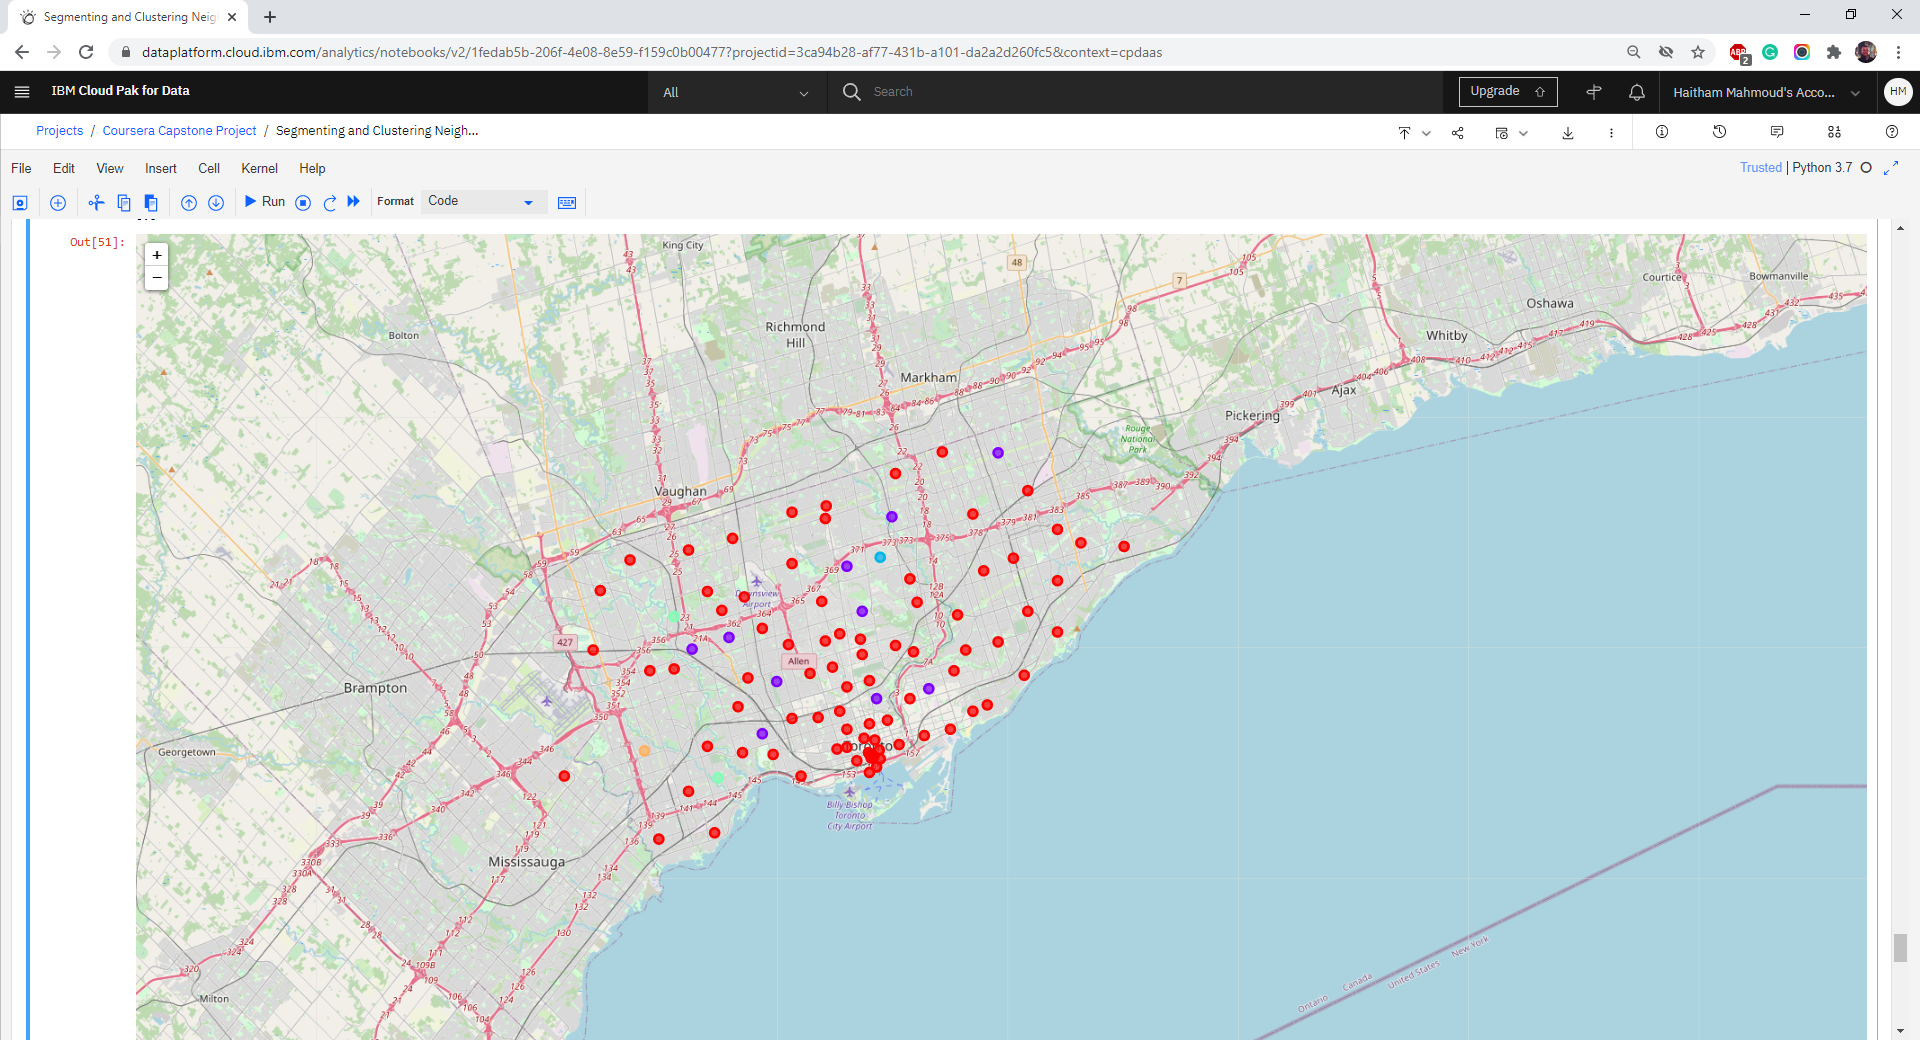

<a id='item5'></a>


## 5. Examine Clusters

Now, you can examine each cluster and determine the discriminating venue categories that distinguish each cluster. Based on the defining categories, you can then assign a name to each cluster. I will leave this exercise to you.

#### Cluster 1

In [52]:
canada_merged.loc[canada_merged['Cluster Labels'] == 0, canada_merged.columns[[1] + list(range(5, canada_merged.shape[1]))]]

Borough  Cluster Labels  1st Most Common Venue  \
0          North York             0.0             Food Truck   
1          North York             0.0  Portuguese Restaurant   
2    Downtown Toronto             0.0            Coffee Shop   
3          North York             0.0         Clothing Store   
4    Downtown Toronto             0.0             Food Truck   
7          North York             0.0             Restaurant   
8           East York             0.0            Pizza Place   
9    Downtown Toronto             0.0            Coffee Shop   
10         North York             0.0                 Bakery   
12        Scarborough             0.0             Food Truck   
13         North York             0.0             Restaurant   
14          East York             0.0           Skating Rink   
15   Downtown Toronto             0.0            Coffee Shop   
16               York             0.0           Hockey Arena   
18        Scarborough             0.0                   Bank   
19       East Toronto             0.0                    Pub   
20   Downtown Toronto             0.0            Coffee Shop   
22        Scarborough             0.0         Cosmetics Shop   
23          East York             0.0    Sporting Goods Shop   
24   Downtown Toronto             0.0            Coffee Shop   
25   Downtown Toronto             0.0          Grocery Store   
26        Scarborough             0.0    Fried Chicken Joint   
27         North York             0.0                   Pool   
28         North York             0.0            Coffee Shop   
29          East York             0.0         Sandwich Place   
30   Downtown Toronto             0.0            Coffee Shop   
31       West Toronto             0.0               Pharmacy   
32        Scarborough             0.0             Playground   
34         North York             0.0          Metro Station   
36   Downtown Toronto             0.0            Coffee Shop   
37       West Toronto             0.0                    Bar   
38        Scarborough             0.0             Hobby Shop   
39         North York             0.0             Restaurant   
40         North York             0.0          Grocery Store   
41       East Toronto             0.0       Greek Restaurant   
42   Downtown Toronto             0.0            Coffee Shop   
43       West Toronto             0.0     Tibetan Restaurant   
44        Scarborough             0.0                 Bakery   
46         North York             0.0          Grocery Store   
47       East Toronto             0.0                    Pub   
48   Downtown Toronto             0.0            Coffee Shop   
50         North York             0.0            Pizza Place   
51        Scarborough             0.0                  Motel   
52         North York             0.0      Korean Restaurant   
53         North York             0.0          Grocery Store   
54       East Toronto             0.0            Coffee Shop   
55         North York             0.0         Sandwich Place   
56               York             0.0         Sandwich Place   
58        Scarborough             0.0        College Stadium   
59         North York             0.0      Korean Restaurant   
60         North York             0.0          Grocery Store   
62    Central Toronto             0.0                 Garden   
63               York             0.0                Brewery   
65        Scarborough             0.0      Indian Restaurant   
67    Central Toronto             0.0         Breakfast Spot   
68    Central Toronto             0.0                   Park   
70          Etobicoke             0.0           Intersection   
71        Scarborough             0.0         Sandwich Place   
72         North York             0.0                Butcher   
73    Central Toronto             0.0         Clothing Store   
74    Central Toronto             0.0         Sandwich Place   
75       West Toronto             0.0         

#### Cluster 2

In [53]:
canada_merged.loc[canada_merged['Cluster Labels'] == 1, canada_merged.columns[[1] + list(range(5, canada_merged.shape[1]))]]

Borough  Cluster Labels  \
21              York             1.0   
33        North York             1.0   
35         East York             1.0   
49        North York             1.0   
61   Central Toronto             1.0   
64              York             1.0   
66        North York             1.0   
69      West Toronto             1.0   
85       Scarborough             1.0   
91  Downtown Toronto             1.0   

                       1st Most Common Venue       2nd Most Common Venue  \
21                                      Park                        Pool   
33                                      Park                    Pharmacy   
35                              Intersection           Convenience Store   
49                                    Bakery  Construction & Landscaping   
61                               Swim School                    Bus Line   
64                                      Park         Xinjiang Restaurant   
66                         Convenience Store                        Park   
69  Residential Building (Apartment / Condo)           Convenience Store   
85                                    Bakery                  Playground   
91                                      Park                  Playground   

   3rd Most Common Venue      4th Most Common Venue 5th Most Common Venue  \
21         Women's Store       Fast Food Restaurant     Electronics Store   
33           Pizza Place  Middle Eastern Restaurant       Laundry Service   
35                  Park                      Field           Escape Room   
49                  Park       Fast Food Restaurant     Electronics Store   
61                  Park       Fast Food Restaurant           Escape Room   
64   Dumpling Restaurant          Electronics Store           Escape Room   
66   Xinjiang Restaurant       Fast Food Restaurant           Escape Room   
69         Bowling Alley                       Park  Fast Food Restaurant   
85                  Park               Intersection                  Food   
91                 Trail               Tennis Court        Farmers Market   

          6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
21                  Escape Room  Ethiopian Restaurant           Event Space   
33                  Coffee Shop       Thai Restaurant     Convenience Store   
35         Ethiopian Restaurant           Event Space    Falafel Restaurant   
49                  Escape Room  Ethiopian Restaurant           Event Space   
61         Ethiopian Restaurant           Event Space    Falafel Restaurant   
64         Ethiopian Restaurant           Event Space    Falafel Restaurant   
66         Ethiopian Restaurant           Event Space    Falafel Restaurant   
69                  Escape Room  Ethiopian Restaurant           Event Space   
85                  Flower Shop           Fish Market     Fish & Chips Shop   
91  Eastern European Restaurant     Electronics Store           Escape Room   

   9th Most Common Venue 10th Most Common Venue  
21    Falafel Restaurant         Farmers Market  
33             Wine Shop          Deli / Bodega  
35        Farmers Market   Fast Food Restaurant  
49    Falafel Restaurant         Farmers Market  
61        Farmers Market    Xinjiang Restaurant  
64        Farmers Market   Fast Food Restaurant  
66        Farmers Market                  Field  
69    Falafel Restaurant         Farmers Market  
85   Filipino Restaurant                  Field  
91  Ethiopian Restaurant            Event Space

#### Cluster 3

In [54]:
canada_merged.loc[canada_merged['Cluster Labels'] == 2, canada_merged.columns[[1] + list(range(5, canada_merged.shape[1]))]]

Borough  Cluster Labels 1st Most Common Venue 2nd Most Common Venue  \
45  North York             2.0   Martial Arts School   Xinjiang Restaurant   

   3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
45                 Field           Escape Room  Ethiopian Restaurant   

   6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
45           Event Space    Falafel Restaurant        Farmers Market   

   9th Most Common Venue 10th Most Common Venue  
45  Fast Food Restaurant    Filipino Restaurant

#### Cluster 4

In [55]:
canada_merged.loc[canada_merged['Cluster Labels'] == 3, canada_merged.columns[[1] + list(range(5, canada_merged.shape[1]))]]

Borough  Cluster Labels 1st Most Common Venue  \
57   North York             3.0        Baseball Field   
101   Etobicoke             3.0        Baseball Field   

          2nd Most Common Venue 3rd Most Common Venue 4th Most Common Venue  \
57          Xinjiang Restaurant            Food Truck           Escape Room   
101  Construction & Landscaping   Xinjiang Restaurant                 Field   

    5th Most Common Venue 6th Most Common Venue 7th Most Common Venue  \
57   Ethiopian Restaurant           Event Space    Falafel Restaurant   
101  Ethiopian Restaurant           Event Space    Falafel Restaurant   

    8th Most Common Venue 9th Most Common Venue 10th Most Common Venue  
57         Farmers Market  Fast Food Restaurant                  Field  
101        Farmers Market  Fast Food Restaurant    Filipino Restaurant

#### Cluster 5

In [56]:
canada_merged.loc[canada_merged['Cluster Labels'] == 4, canada_merged.columns[[1] + list(range(5, canada_merged.shape[1]))]]

Borough  Cluster Labels 1st Most Common Venue 2nd Most Common Venue  \
11  Etobicoke             4.0            Print Shop   Xinjiang Restaurant   

   3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
11  Fast Food Restaurant     Electronics Store           Escape Room   

   6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
11  Ethiopian Restaurant           Event Space    Falafel Restaurant   

   9th Most Common Venue 10th Most Common Venue  
11        Farmers Market                  Field